# Brain Tumor Detector

## Definition of the Dataset

We decided to use the dataset : https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

It contains:
- 253 MRI images in total
- 98 No Tumor (38.74%)
- 155 Yes Tumor (61.26%)


## Installation and Import Packages

### Installation

In [49]:
%pip install numpy
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install opencv-python
%pip install torchvision
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importing Packages 

In [50]:
import numpy as np
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import cv2



## Reading MRI Images

This section reads and processes MRI images of brain scans. It’s divided into two parts: loading images with tumors and loading images without tumors.

In [51]:

# Load and process images from the dataset, return as numpy array
def load_and_process_images(path, size=(128, 128)):
    images = []
    for file in glob.iglob(path):
        img = cv2.imread(file)
        img = cv2.resize(img, size)
        # Convert from BGR to RGB for visualization consistency
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)


healthy_images = load_and_process_images('data/no/*.jpg')
infected_images = load_and_process_images('data/yes/*.jpg')


## Visualizing Brain MRI Images

The plot_images function is defined to visualize images from each category, "healthy" and "infected":

In [52]:
def plot_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Shape: {img.shape}')
    plt.show()

The images parameter receives a random list of images of each category.

<Figure size 1600x900 with 0 Axes>

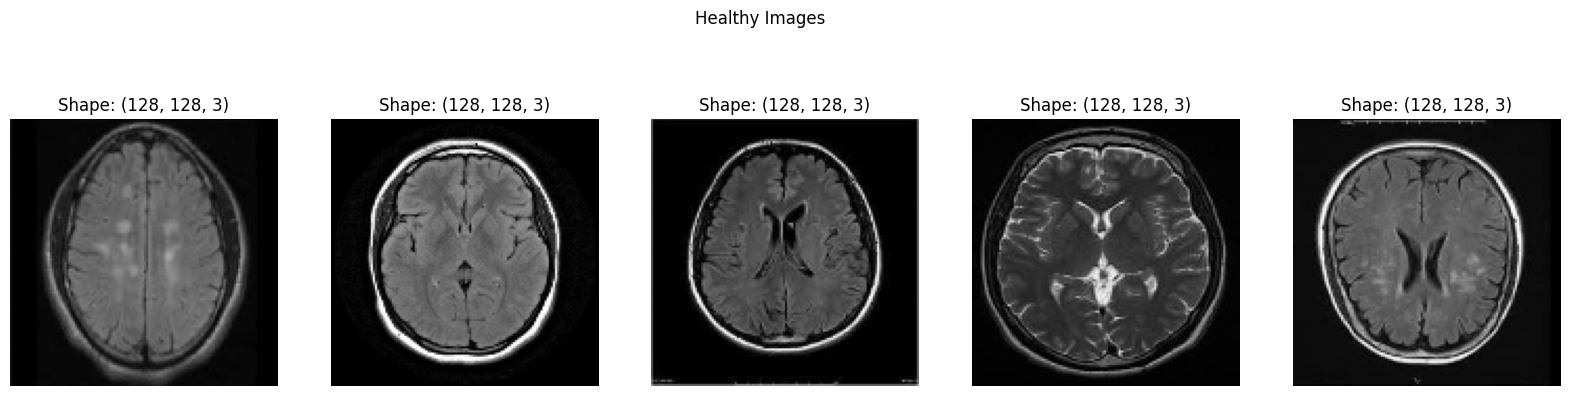

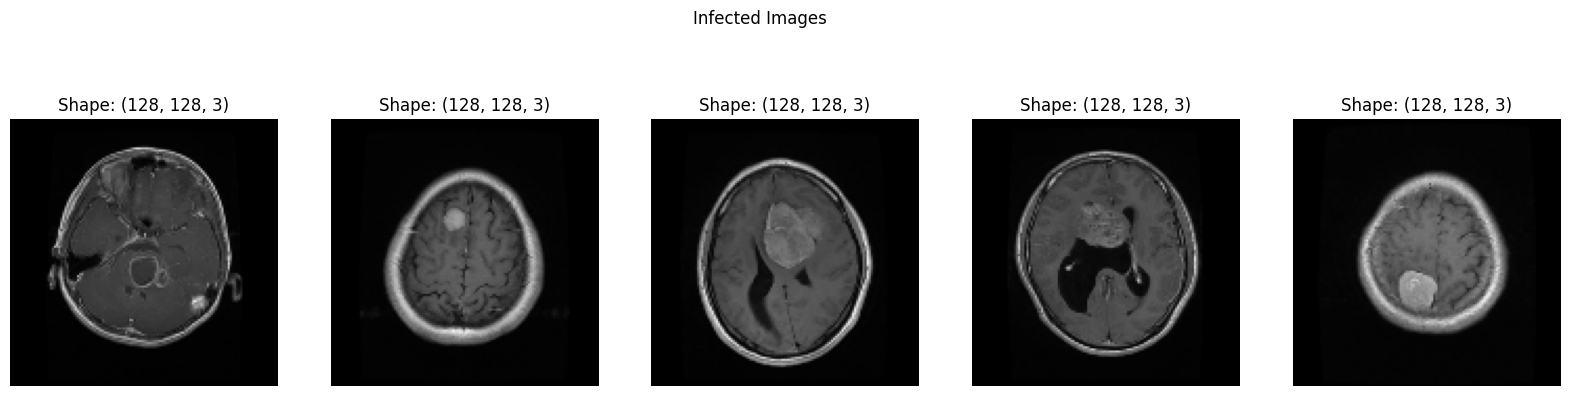

In [53]:
plt.figure(figsize=(16,9))

# Plot some healthy and infected images to visualize the data
plot_images(healthy_images[np.random.choice(healthy_images.shape[0], 5, replace=False)], 'Healthy Images')
plot_images(infected_images[np.random.choice(infected_images.shape[0], 5, replace=False)], 'Infected Images')

## Creating MRI custom dataset class

In [54]:
class MRIDataset(Dataset):
    def __init__(self, healthy_images, infected_images, transform=None):
        self.healthy_images = healthy_images
        self.infected_images = infected_images
        self.transform = transform
        self.labels = [0] * len(healthy_images) + [1] * len(infected_images)
        self.images = np.concatenate((healthy_images, infected_images), axis=0)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations if needed
transform = None

# Create the dataset
mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

# Create a DataLoader for batching and shuffling
mri_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)

# Data Preprocessing

In [55]:
#Apply transformations for preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mri_dataset = MRIDataset(healthy_images, infected_images, transform=transform)

# Splitting the Dataset

In [56]:
# Split the dataset into train and test sets
data_size = len(mri_dataset)
train_size = int(0.8 * data_size) # 80% of the data is used for training
test_size = data_size - train_size # Remaining 20% is used for testing

train_dataset, test_dataset = random_split(mri_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transfer Learning with ResNet-18

In [57]:
# Use Transfer Learning with Pretrained Model
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        from torchvision.models import ResNet18_Weights
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# Freezing Base Model Layers

In [58]:
# Initialize model, loss function, and optimizer
model = TransferLearningModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.base_model.fc.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransferLearningModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# Training the Model

In [59]:
# Training loop with Accuracy Tracking
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    train_accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        train_accuracies.append(accuracy)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}")
    return train_accuracies


# Evaluating the Model

In [60]:
# Evaluation loop
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    cm = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Tumor'], yticklabels=['Healthy', 'Tumor'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return acc, precision, recall, f1, cm


# Visualization

In [61]:
# Plotting Metrics
def plot_metrics(metrics, metric_names):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(metrics[0]) + 1), metrics[0], label=metric_names[0])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def plot_bar_metrics(acc, precision, recall, f1):
    metric_values = [acc, precision, recall, f1]
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=metric_labels, y=metric_values, palette='viridis')
    plt.ylabel('Score')
    plt.title('Evaluation Metrics')
    plt.ylim(0, 1)
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.show()


In [62]:
# Train the model
train_accuracies = train_model(model, train_loader, criterion, optimizer, epochs=20)



Epoch [1/20], Loss: 0.4674, Accuracy: 0.7750
Epoch [2/20], Loss: 0.2856, Accuracy: 0.8766
Epoch [3/20], Loss: 0.2408, Accuracy: 0.8969
Epoch [4/20], Loss: 0.1837, Accuracy: 0.9281
Epoch [5/20], Loss: 0.1817, Accuracy: 0.9313
Epoch [6/20], Loss: 0.1805, Accuracy: 0.9281
Epoch [7/20], Loss: 0.1282, Accuracy: 0.9578
Epoch [8/20], Loss: 0.1362, Accuracy: 0.9484
Epoch [9/20], Loss: 0.1129, Accuracy: 0.9531
Epoch [10/20], Loss: 0.0952, Accuracy: 0.9625
Epoch [11/20], Loss: 0.0995, Accuracy: 0.9563
Epoch [12/20], Loss: 0.1030, Accuracy: 0.9563
Epoch [13/20], Loss: 0.0945, Accuracy: 0.9703
Epoch [14/20], Loss: 0.1279, Accuracy: 0.9453
Epoch [15/20], Loss: 0.1241, Accuracy: 0.9516
Epoch [16/20], Loss: 0.0920, Accuracy: 0.9703
Epoch [17/20], Loss: 0.0512, Accuracy: 0.9891
Epoch [18/20], Loss: 0.0578, Accuracy: 0.9828
Epoch [19/20], Loss: 0.0626, Accuracy: 0.9844
Epoch [20/20], Loss: 0.0696, Accuracy: 0.9750


Accuracy: 0.9625
Precision: 0.9524
Recall: 0.9756
F1-score: 0.9639


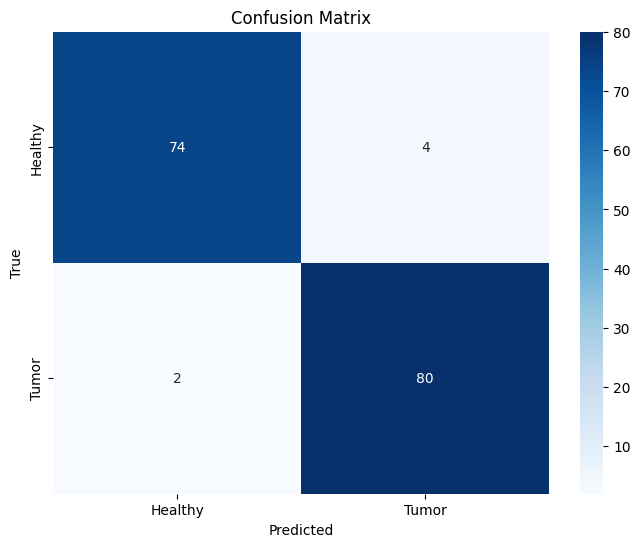

In [63]:
# Evaluate the model
evaluation_results = evaluate_model(model, test_loader)

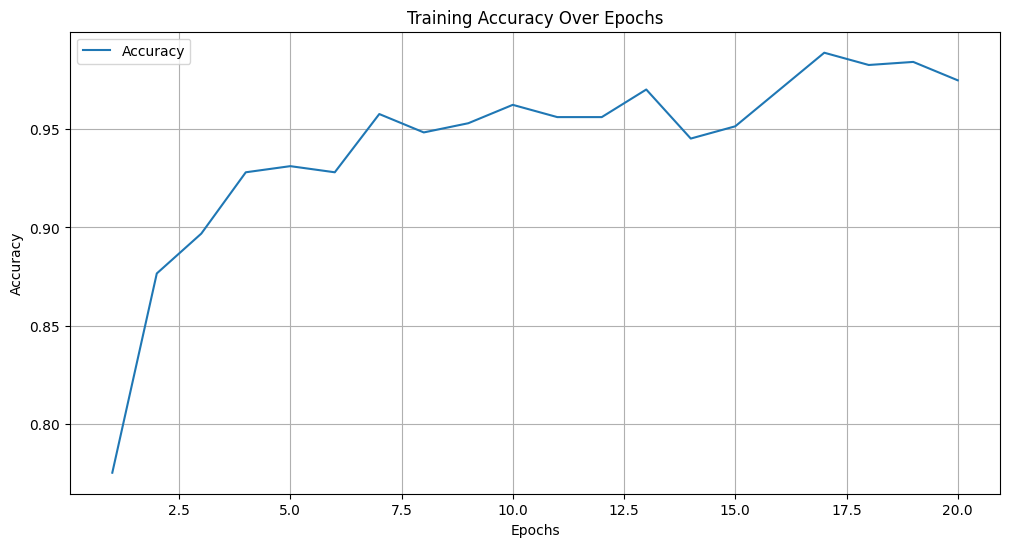

C:\Users\vulpe\AppData\Local\Temp\ipykernel_37976\4135774315.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_labels, y=metric_values, palette='viridis')


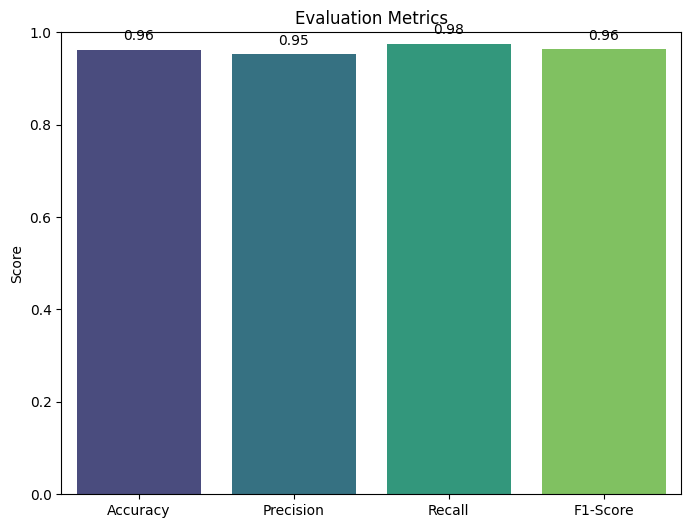

In [64]:
# Collect evaluation metrics for graph plotting
acc, precision, recall, f1, _ = evaluation_results

# Plot training accuracy
plot_metrics([train_accuracies], ['Accuracy'])

# Plot bar diagram for evaluation metrics
plot_bar_metrics(acc, precision, recall, f1)

### Testing our Model with new Data

In [72]:
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F  # For Softmax
from torchvision import transforms

# --- CNN-Modellklasse ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        self.fc_model = nn.Sequential(
            nn.Linear(16 * 29 * 29, 120),  # Adjust based on the input size
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 2),  # Output for 2 classes (Healthy, Tumor)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_model(x)
        return x


# --- Transformation für Bilder ---
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize as in training
])


# --- Bildvorverarbeitung ---
def preprocess_new_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image could not be loaded: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_transformed = transform(img)  # Apply transformations
    img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension
    return img_transformed


# --- Vorhersage mit Wahrscheinlichkeiten ---
def predict_with_probability(model, image_tensor, device):
    class_labels = ["Healthy", "Tumor"]  # Define class labels
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(image_tensor.to(device))  # Logits
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Class with highest probability
        confidence = probabilities[0, predicted_class].item()  # Confidence for the predicted class

    predicted_label = class_labels[predicted_class]
    return predicted_label, confidence


# --- Speichern des Modells (nur Gewichte) ---
def save_model_weights(model, save_path):
    torch.save(model.state_dict(), save_path)
    print(f"Modellgewichte wurden erfolgreich unter {save_path} gespeichert.")


# --- Laden des Modells (nur Gewichte) ---
def load_model_weights(model, save_path, device):
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    print(f"Modellgewichte wurden erfolgreich von {save_path} geladen.")
    return model


# --- Hauptteil ---
if __name__ == "__main__":
    # Datei- und Modellpfade
    model_weights_path = "models/cnn_weights.pth"
    new_image_path = "data/new/image.jpg"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialisiere und speichere Modellgewichte
    model = CNN().to(device)
    save_model_weights(model, model_weights_path)

    # Lade Modellgewichte
    model = load_model_weights(CNN(), model_weights_path, device)

    # Verarbeite neues Bild und mache Vorhersage
    try:
        processed_image = preprocess_new_image(new_image_path)
        predicted_label, confidence = predict_with_probability(model, processed_image, device)
        print(f"Vorhersage: {predicted_label}, Vertrauen: {confidence:.2f}")
    except Exception as e:
        print(f"Fehler: {e}")


Modellgewichte wurden erfolgreich unter models/cnn_weights.pth gespeichert.
Modellgewichte wurden erfolgreich von models/cnn_weights.pth geladen.
Vorhersage: Healthy, Vertrauen: 0.54


C:\Users\vulpe\AppData\Local\Temp\ipykernel_37976\1745745658.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=de